In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import *   #compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units

import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background

from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy')

if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.
perc_step = 5

CHANGED END DATE OF SLICING ON 28TH JUNE 2024

In [6]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


In [7]:
# daily varaibles
# select sst, q2, U, PBLH
sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
sst = sst.where(sea_mask_modified, drop=False)
sst_day = sst.groupby('time_counter.day').mean()
              
q2_day = ds_hourly['Q2'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
#q2_day = q2_day.groupby('time_counter.day').mean()
q2_day = q2_day[::3]
q2_day = q2_day.where(sea_mask_modified, drop=False).values;                 

PBLH_day = ds_hourly['PBLH'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
PBLH_day = PBLH_day.groupby('time_counter.day').mean()
PBLH_day = PBLH_day.where(sea_mask_modified, drop=False).values;          

T2_day = ds_hourly['T2'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
#T2_day = T2_day.groupby('time_counter.day').mean()
T2_day = T2_day[::3]
T2_day = T2_day.where(sea_mask_modified, drop=False).values

In [7]:
dsst_day = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_feb.nc')
dsst_day = dsst_day['dsst_day']

In [9]:
# retrieving pressure field

pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')]);  pres = pres['P']
pres = pres.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
pres = (pres+pres_base)/100.


pres = pres.where(sea_mask_modified, drop=False)


del pres_base

In [10]:
# retrieving pressure at surface level
pres_sfc = pres[:,0,:,:]
'''#pres_sfc = pres_sfc.where(sea_mask, drop=False)
pres_sfc = pres_sfc.groupby('time_counter.day').mean()'''

"#pres_sfc = pres_sfc.where(sea_mask, drop=False)\npres_sfc = pres_sfc.groupby('time_counter.day').mean()"

In [13]:
# reading geopotential height
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']/9.81

GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
GPH = GPH['PH']/9.81

GPH = GPH_base + GPH
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask_modified, drop=False)

#GPH = GPH.groupby('time_counter.day').mean()

#GPH_base = GPH_base.where(sea_mask, drop=False)
del GPH_base

In [10]:
GPH_mean = GPH.mean(axis=(0,2,3))
# vertical interpolation of geopotential
# GPH_inter = np.zeros_like(pot_temp)
for i in range(39):
    GPH_mean[i] = (GPH_mean[i+1]+GPH_mean[i])*0.5

In [12]:
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

COMPUTE LCL WITH lcl.py

In [13]:
# compute surface saturation specific humidity
rh_sea = meteo.rhcalc(T2_day-273.15, pres_sfc, q2_day)/100.        # in meteo.py, they multiplied by 100

# daily means of RH

rh_day_sea = np.zeros((29,) + rh_sea.shape[1:])
i = np.arange(29).astype(int)
for j in i:
    rh_day_sea[j] = np.nanmean(rh_sea[j*8:(j+1)*8], axis=0)



In [25]:
# compute lcl with loops
LCL_sea = np.zeros_like(rh_sea)

# vectorize lcl function!
vectorized_lcl = np.vectorize(lcl.lcl)
LCL_sea = vectorized_lcl(pres_sfc*100, T2_day, rh_sea)


In [27]:
## daily mean of LCL
# daily means of RH
LCL_day_sea = np.zeros((29,) + LCL_sea.shape[1:])
i = np.arange(29).astype(int)
for j in i:
    LCL_day_sea[j] = np.nanmean(LCL_sea[j*8:(j+1)*8], axis=0)

In [31]:
LCL_day_xr = xr.DataArray(LCL_day_sea, dims=['day', 'lat', 'lon'], name='LCL_day')
LCL_day_xr.attrs['long_name'] = 'LCL daily mean in feb. with latest mask'
LCL_day_xr.attrs['unit'] = 'metres [m]'


rh_day_xr = xr.DataArray(rh_day_sea, dims=['day', 'lat', 'lon'], name='LCL_day')
rh_day_xr.attrs['long_name'] = 'RH daily mean in feb. with latest mask'
rh_day_xr.attrs['unit'] = 'dimensionless'



In [37]:
PBLH_day = ds_hourly['PBLH'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
PBLH_day = PBLH_day.groupby('time_counter.day').mean()
PBLH_day = PBLH_day.where(sea_mask_modified, drop=False).values; 

In [47]:
# actual computation of smoothed fields

# compute anomalies daily data
s = 100

# initialize anomalies
#dsst_day = np.zeros(sst_day.shape)
dPBLH_day = np.zeros(PBLH_day.shape)
dLCL_day = np.zeros(LCL_day_sea.shape)


for t in range(0,LCL_day_sea.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    '''sst_day_ave = gm.nan_gaussian_filter(sst_day[t],s)          
    dsst_day[t] = sst_day[t] - sst_day_ave'''
    
    PBLH_day_ave = gm.nan_gaussian_filter(PBLH_day[t],s)        
    dPBLH_day[t] = PBLH_day[t] - PBLH_day_ave
    
    LCL_day_ave = gm.nan_gaussian_filter(LCL_day_sea[t],s)          
    dLCL_day[t] = LCL_day_sea[t] - LCL_day_ave
    

0
10
20


In [48]:
dLCL_day_xr = xr.DataArray(dLCL_day, dims=['day', 'lat', 'lon'], name='LCL_day')
dLCL_day_xr.attrs['long_name'] = 'LCL daily anomalies in feb. with latest mask'
dLCL_day_xr.attrs['unit'] = 'metres [m]'


dPBLH_day_xr = xr.DataArray(dPBLH_day, dims=['day', 'lat', 'lon'], name='PBLH_day')
dPBLH_day_xr.attrs['long_name'] = 'PBLH daily anomalies in feb. with latest mask'
dPBLH_day_xr.attrs['unit'] = 'metres [m]'

In [46]:
LCL_day_sea.shape

(29, 546, 573)

In [40]:
LCL = xr.Dataset({
    'LCL_day': LCL_day_xr,
    'dLCL_day': dLCL_day_xr
})

LCL.to_netcdf(path='/venus/tesi_ale/data_EU/LCL/daily/FEB/LCL_feb.nc')

In [49]:
PBLH_pr = mpcalc.height_to_pressure_std(PBLH_day*units.meters).to('hPa')

PBLH_pr = xr.DataArray(PBLH_pr.magnitude, dims=['day', 'lat', 'lon'], name='PBLH_pr')
PBLH_pr.attrs['long_name'] = 'PBLH daily mean height in pressure values'
PBLH_pr.attrs['unit'] = 'hectopascals [hPa]'

PBLH = xr.Dataset({
    'PBLH_pr': PBLH_pr,
    'dPBLH_day': dPBLH_day_xr
})

PBLH.to_netcdf(path='/venus/tesi_ale/data_EU/PBLH/daily/FEB/PBLH_day_feb.nc')

OPEN NEWLY SAVED DATASETS HERE

In [14]:
ds_pblh = xr.open_dataset('/venus/tesi_ale/data_EU/PBLH/daily/FEB/PBLH_day_feb.nc')
ds_lcl = xr.open_dataset('/venus/tesi_ale/data_EU/LCL/daily/FEB/LCL_feb.nc')

In [19]:
ds_pblh

<xarray.Dataset>
Dimensions:    (day: 29, lat: 546, lon: 573)
Dimensions without coordinates: day, lat, lon
Data variables:
    PBLH_pr    (day, lat, lon) float32 ...
    dPBLH_day  (day, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [16]:
# DISTRIBUTION PBLH_ave / LCL_ave vs SST_ave bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins
popmean = 0.

In [17]:
# PERC DISTRIBUTION ANOMALIES

pdist_dsst, pdist_dPBLH_dsst, pstd_dPBLH_dsst, pstderr_dPBLH_dsst, pnpoints_dPBLH_dsst, ppvalue_dPBLH_dsst = \
distrib_2d(dsst_day.values, ds_pblh['dPBLH_day'].values, perc_step, nbins, popmean, perc_fixbin = 'perc')

pdist_dsst, pdist_dLCL_dsst, pstd_dLCL_dsst, pstderr_dLCL_dsst, pnpoints_dLCL_dsst, ppvalue_dLCL_dsst = \
distrib_2d(dsst_day.values, ds_lcl['dLCL_day'].values, perc_step, nbins, popmean, perc_fixbin = 'perc')


In [18]:
### FULL FIELDS

pdist_sst, pdist_PBLH_sst, pstd_PBLH_sst, pstderr_PBLH_sst, pnpoints_PBLH_sst, ppvalue_PBLH_sst = \
distrib_2d(sst_day.values, PBLH_day, perc_step, nbins, popmean, perc_fixbin = 'perc')

pdist_sst, pdist_LCL_sst, pstd_LCL_sst, pstderr_LCL_sst, pnpoints_LCL_sst, ppvalue_LCL_sst = \
distrib_2d(sst_day.values, ds_lcl['LCL_day'].values, perc_step, nbins, popmean, perc_fixbin = 'perc')

In [45]:
pdist_dsst, pdist_PBLHpr_dsst, pstd_PBLHpr_dsst, pstderr_PBLHpr_dsst, pnpoints_PBLHpr_dsst, ppvalue_PBLHpr_dsst = \
distrib_2d(dsst_day.values, ds_pblh['PBLH_pr'].values, perc_step, nbins, popmean, perc_fixbin = 'perc')

xr_pdist_dsst = xr.DataArray(pdist_dsst, dims=['dsst'], name='pdist_dsst')
xr_pdist_dsst.attrs['long_name'] = '5% percentiles of dsst with latest mask'
xr_pdist_dsst.attrs['units'] = 'degree K'

xr_pdist_PBLHpr_dsst = xr.DataArray(pdist_PBLHpr_dsst, dims=['dsst'], name='pdist_PBLHpr_dsst')
xr_pdist_PBLHpr_dsst.attrs['long_name'] = '5% percentiles of PBLHpr with latest mask'
xr_pdist_PBLHpr_dsst.attrs['units'] = 'hectopascals [hPa]'

xr_pstd_PBLHpr_dsst = xr.DataArray(pstd_PBLHpr_dsst, dims=['dsst'], name='pstd_PBLHpr_dsst')
xr_pstd_PBLHpr_dsst.attrs['long_name'] = 'resulting PBLHpr std dev per percentile bin'

xr_pstderr_PBLHpr_dsst = xr.DataArray(pstderr_PBLHpr_dsst, dims=['dsst'], name='pstderr_PBLHpr_dsst')
xr_pstderr_PBLHpr_dsst.attrs['long_name'] = 'resulting PBLHpr stderr per percentile bin'

xr_pnpoints_PBLHpr_dsst = xr.DataArray(pnpoints_PBLHpr_dsst, dims=['dsst'], name='pnpoints_PBLHpr_dsst')
xr_pnpoints_PBLHpr_dsst.attrs['long_name'] = 'number of points in every bin'

xr_ppvalue_PBLHpr_dsst = xr.DataArray(ppvalue_PBLHpr_dsst, dims=['dsst'], name='ppvalue_PBLHpr_dsst')
xr_ppvalue_PBLHpr_dsst.attrs['long_name'] = 'computed pvalues'


# If you want to put them in a dataset
dataset = xr.Dataset({
    'pdist_dsst': xr_pdist_dsst,
    'pdist_PBLHpr_dsst': xr_pdist_PBLHpr_dsst,
    'pstd_PBLHpr_dsst': xr_pstd_PBLHpr_dsst,
    'pstderr_PBLHpr_dsst': xr_pstderr_PBLHpr_dsst,
    'pnpoints_PBLHpr_dsst': xr_pnpoints_PBLHpr_dsst,
    'ppvalue_PBLHpr_dsst': xr_ppvalue_PBLHpr_dsst
})

dataset.to_netcdf(path='/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLHpr_dsst_day_feb.nc')

/venus/tesi_ale/img_EU/PBLH/daily/FEB/pdist_sst-PBLHLCL_dsst_dPBLHdLCL_UpdatedMask.png


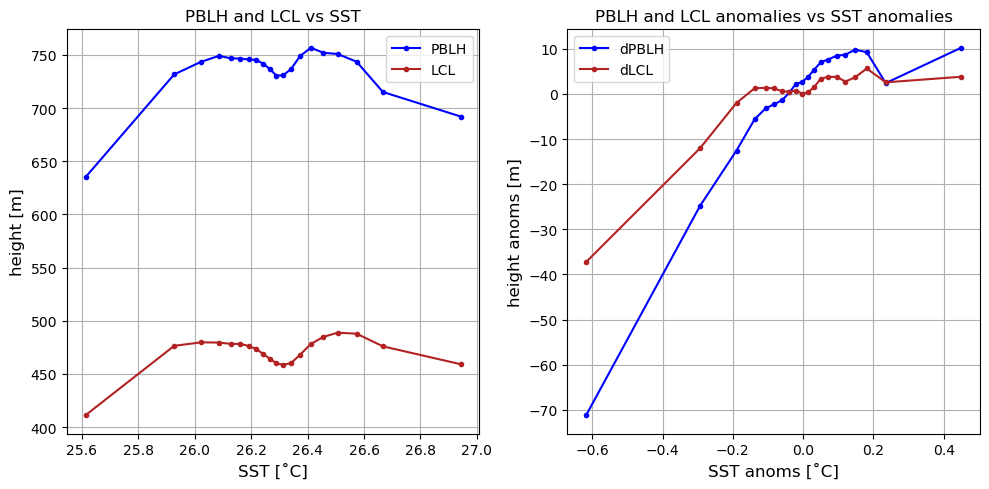

In [30]:
###### Figure


fig, (ax1, ax) = plt.subplots(1,2, figsize=(10,5))


ax1.plot(pdist_sst-273.15, pdist_PBLH_sst, '.-',color='b', label='PBLH')
ax1.plot(pdist_sst-273.15, pdist_LCL_sst, '.-',color='firebrick', label='LCL')


#ax1.errorbar(pdist_sst-273.15, pdist_PBLH_sst, yerr=pstd_PBLH_sst, xerr=None,\
#             label='PBLH', ecolor='b', linestyle='-', color='b')
#ax1.errorbar(pdist_sst-273.15, pdist_LCL_sst, yerr=pstd_LCL_sst, xerr=None,\
#             label='LCL', ecolor='firebrick', linestyle='-', color='firebrick')
ax1.legend()

ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST [˚C]', fontsize=12); 
ax1.grid(); ax1.set_title('PBLH and LCL vs SST')



ax.plot(pdist_dsst, pdist_dPBLH_dsst, '.-',color='b', label='dPBLH')
ax.plot(pdist_dsst, pdist_dLCL_dsst, '.-',color='firebrick', label='dLCL')
#ax.errorbar(pdist_sst-273.15, pdist_dPBLH_dsst, yerr=pstd_PBLH_sst, xerr=None,\
#             label='dPBLH', ecolor='b', linestyle='-', color='b')
#ax.errorbar(pdist_sst-273.15, pdist_dLCL_dsst, yerr=pstd_LCL_sst, xerr=None,\
#             label='dLCL', ecolor='firebrick', linestyle='-', color='firebrick')


ax.legend()

ax.set_ylabel('height anoms [m]', fontsize=12); ax.set_xlabel('SST anoms [˚C]', fontsize=12); 
ax.grid(); ax.set_title('PBLH and LCL anomalies vs SST anomalies')

plt.tight_layout()


path_img = '/venus/tesi_ale/img_EU/PBLH/daily/FEB/' 
filename = path_img + 'pdist_sst-PBLHLCL_dsst_dPBLHdLCL_UpdatedMask.png' 
# plt.savefig(filename)
print(filename)
del filename


/venus/tesi_ale/img_EU/PBLH/daily/FEB/scatterPercentiles_sst_PBLH_feb.png


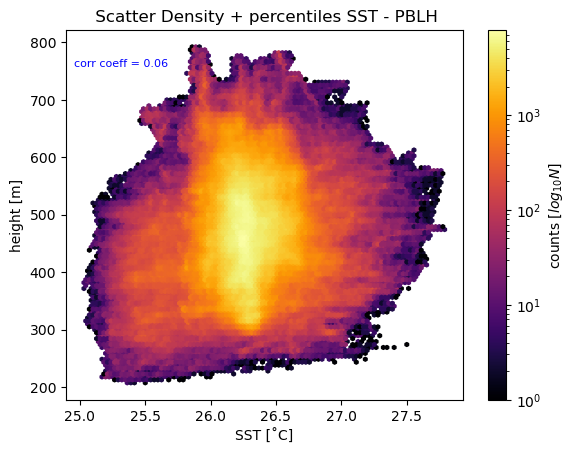

In [26]:
dsst = False

fig, ax1 = plt.subplots()


if not dsst:
    x =  (sst_day-273.15).values
    y =  PBLH_day
    yy = ds_lcl['LCL_day'].values
    fit_PBLH, corcoe_PBLH, p_value_PBLH, p_val_cann_PBLH, sigmas_full_PBLH = slopes_r_p_mix(x, y, nt, nskip)
    fit_LCL, corcoe_LCL, p_value_LCL, p_val_cann_LCL, sigmas_full_LCL = slopes_r_p_mix(x, yy, nt, nskip)
    
    title=' Scatter Density + percentiles SST - PBLH'  # and LCL'
    xlabel='SST [˚C]'
    ylabel='height [m]'
    
else:
    x = dsst_day.values   
    y = ds_pblh['dPBLH_day'].values   
    yy = ds_lcl['dLCL_day'].values
    fit_dPBLH, corcoe_dPBLH, p_value_dPBLH, p_val_cann_dPBLH, sigmas_dPBLH = slopes_r_p_mix(x, y, nt, nskip)
    fit_dLCL, corcoe_dLCL, p_value_dLCL, p_val_cann_dLCL, sigmas_dLCL = slopes_r_p_mix(x, yy, nt, nskip)
    
    title='Scatter Density + percentiles dSST - dPBLH'  # and dLCL'
    xlabel='SST anoms [K]'
    ylabel='height anoms [m]'
    '''miny = -150 ; maxy = 100
    minx = -2 ; maxx = 1'''
    

pos = [0.02,0.95]    
    
density_hexbin(x, yy, fit=None, corcoe=corcoe_LCL, grdsz=100, \
                        title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos)

# ax1.plot(pdist_sst-273.15, pdist_PBLH_sst, '.-',color='b', label='PBLH')








# if p_val_cann_LCL < 0.05:
#     plt.annotate('slope p value < 0.05', xy=(pos[0], pos[1]-0.1), \
#                          xycoords='axes fraction', fontsize=8, color='b')
# else:
#     plt.annotate('slope p value > 0.05', xy=(pos[0], pos[1]-0.1), \
#                          xycoords='axes fraction', fontsize=8, color='b')

    

path_img = '/venus/tesi_ale/img_EU/PBLH/daily/FEB/' 
filename = path_img + 'scatterPercentiles_dsst_dPBLH_feb.png' if dsst else path_img + 'scatterPercentiles_sst_PBLH_feb.png'
# plt.savefig(filename)
print(filename)
del filename

## PBLH vs LCL

In [27]:
# PERC DISTRIBUTION ANOMALIES

pdist_dLCL, pdist_dPBLH, pstd_dPBLH, pstderr_dPBLH, pnpoints_dPBLH, ppvalue_dPBLH = \
distrib_2d(ds_lcl['dLCL_day'].values, ds_pblh['dPBLH_day'].values, perc_step, nbins, popmean, perc_fixbin = 'perc')


### FULL FIELDS

pdist_LCL, pdist_PBLH, pstd_PBLH, pstderr_PBLH, pnpoints_PBLH, ppvalue_PBLH = \
distrib_2d(ds_lcl['LCL_day'].values, PBLH_day, perc_step, nbins, popmean, perc_fixbin = 'perc')


/venus/tesi_ale/img_EU/PBLH/daily/FEB/scatterPercentiles_dPBLH-dLCL_feb.png


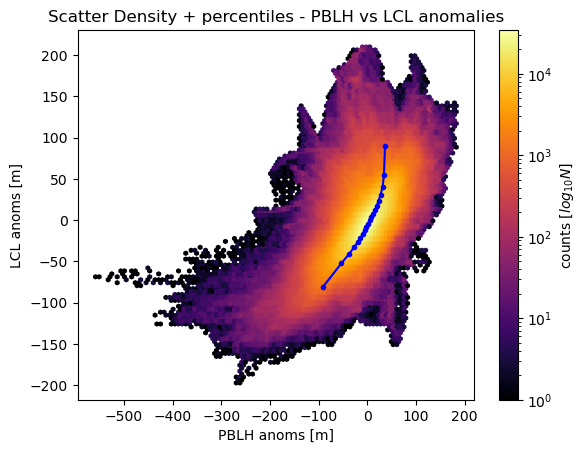

In [45]:
anoms = True

fig, ax1 = plt.subplots()


if not anoms:
    y =  PBLH_day
    yy = ds_lcl['LCL_day'].values
    fit_PBLH_LCL, corcoe_PBLH_LCL, p_value_PBLH_LCL, p_val_cann_PBLH_LCL, sigmas_full_PBLH_LCL = slopes_r_p_mix(y, yy, nt, nskip)
    
    y_perc = pdist_PBLH
    yy_perc = pdist_LCL
    
    title=' Scatter Density + percentiles - PBLH vs LCL' 
    xlabel='PBLH [m]'
    ylabel='LCL [m]'
    
else:   
    y = ds_pblh['dPBLH_day'].values   
    yy = ds_lcl['dLCL_day'].values
    fit_dPBLH_dLCL, corcoe_dPBLH_dLCL, p_value_dPBLH_dLCL, p_val_cann_dPBLH_dLCL, sigmas_dPBLH_dLCL = slopes_r_p_mix(y, yy, nt, nskip)
    
    y_perc = pdist_dPBLH
    yy_perc = pdist_dLCL
    
    title='Scatter Density + percentiles - PBLH vs LCL anomalies'
    xlabel='PBLH anoms [m]'
    ylabel='LCL anoms [m]'
    '''miny = -150 ; maxy = 100
    minx = -2 ; maxx = 1'''
    

pos = [0.02,0.95]    
    
density_hexbin(y, yy, plot_fit=False, fit=None, corcoe=None, grdsz=100, \
                        title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos)

ax1.plot(y_perc, yy_perc, '.-',color='b', label='PBLH')




pval = p_val_cann_dPBLH_dLCL if anoms else p_val_cann_PBLH_LCL

# if pval < 0.05:
#     plt.annotate('slope p value < 0.05', xy=(pos[0], pos[1]-0.1), \
#                          xycoords='axes fraction', fontsize=8, color='b')
# else:
#     plt.annotate('slope p value > 0.05', xy=(pos[0], pos[1]-0.1), \
#                          xycoords='axes fraction', fontsize=8, color='b')

    

path_img = '/venus/tesi_ale/img_EU/PBLH/daily/FEB/' 
filename = path_img + 'scatterPercentiles_dPBLH-dLCL_feb.png' if anoms else path_img + 'scatterPercentilesFIT_PBLH-LCL_feb.png'
# plt.savefig(filename)
print(filename)
del filename

In [ ]:
# corr length
L = 80
nskip = int(L/3)
nt = int(3)
nbin = 50

# linear regression PBLH vs SST
x = dsst_day[::nt,::nskip,::nskip].copy()
# y = dPBLH[::nt,::nskip,::nskip].copy()
y = (ds_pblh['dPBLH_day'].values - ds_lcl['dLCL_day'].values)[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

# scatterplot lin regression 
title = "PBLH' vs SST' - sigma "
xlabel = 'SST anomalies [°C]'; ylabel = "PBLH anomalies [m]"

#                      X ,Y,       fit,     title, xlabel, ylabel, fig
fig1 = scatterplot_fit(x, y, linreg_res, title, xlabel, ylabel, fig)   # s

'''# histogram 2d 
plt.subplot(1,2,2)
fig2 = hist2d(x, y, s, nbin, title, xlabel, ylabel, fig)'''

In [ ]:
# CHECKING BEHAVIOURS OF AVERAGE FIELDS

In [ ]:
# DISTRIBUTION PBLH_ave / LCL_ave vs SST_ave bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [ ]:
# PERC DISTRIBUTION
x = sst_day_ave.copy()
control = x.reshape(-1)

##### Perc distribution: PBLH
# returns:   pdist_control , pdist_var  ,  std deviation  ,   std error 

y = PBLH_day_ave[:,:,:].copy()
variable = y.reshape(-1)
pdist_sst_ave, pdist_PBLH_sst_ave, pstd_PBLH_sst_ave, pstd_err_PBLH_sst_ave = perc_distribution(control, variable, nbins, perc_step)
# pdist_control , pdist_var  ,  std deviation  ,   std error 


##### Perc distribution: LCL
y = LCL_day_ave[:,:,:].copy()
variable = y.reshape(-1)
pdist_sst_ave, pdist_LCL_sst_ave, pstd_LCL_sst_ave, pstd_err_LCL_sst_ave = perc_distribution(control, variable, nbins, perc_step)

In [ ]:
# FIXED BIN DISTRIBUTION
x = sst_day_ave.copy()
control = x.reshape(-1)

##### Fixed bin distribution: PBLH
# returns:   dist_control , dist_var  ,  std dev of mean  , num of points per bin

y = PBLH_day_ave[:,:,:].copy()
variable = y.reshape(-1)
dist_sst_ave, dist_PBLH_sst_ave, std_PBLH_sst_ave, npoints_PBLH = fb_distribution_npoint(control, variable, nbins, perc_step)

##### Fixed bin distribution: LCL
y = LCL_day_ave[:,:,:].copy()
variable = y.reshape(-1)
dist_sst_ave, dist_LCL_sst_ave, std_LCL_sst_ave, npoints_LCL = fb_distribution_npoint(control, variable, nbins, perc_step)

In [ ]:
dist_PBLH_sst_ave

In [ ]:
###### Figure
'''fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.'''

fig, ax = plt.subplots(1,2)

# PERCENTILES
ax[0].plot(pdist_sst_ave-273.15, pdist_PBLH_sst_ave, '.-',color='b', label='PBLH')
ax[0].plot(pdist_sst_ave-273.15, pdist_LCL_sst_ave, '.-',color='firebrick', label='LCL')
ax[0].legend()

ax[0].set_ylabel('height [m]', fontsize=12); ax[0].set_xlabel('SST [˚C]', fontsize=12); 
ax[0].grid(); ax[0].set_title('PDist, average fields')


# FIXED BINS
ax[1].plot(dist_sst_ave-273.15, dist_PBLH_sst_ave, '.-',color='b', label='PBLH')
ax[1].plot(dist_sst_ave-273.15, dist_LCL_sst_ave, '.-',color='firebrick', label='LCL')
ax[1].legend()

#ax[1].set_ylabel('height [m]', fontsize=12); 
ax[1].set_xlabel('SST [˚C]', fontsize=12); 
ax[1].grid(); ax[1].set_title('Fixed bins, average fields')


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)


#plt.savefig('/home/alessandro/prove/primi_plot/pbl_mask/average_PBL_LCL')


In [ ]:
# # DISTRIBUTION PBLH/LCL vs SST bin - DAILY
# DONE ABOVE

In [ ]:
# DISTRIBUTION PBLH/LCL vs SST bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [ ]:
# PERC DISTRIBUTION
x = sst_day.copy()
control = x.reshape(-1)

##### Perc distribution: PBLH
y = PBLH_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_sst, pdist_PBLH, pstd_PBLH, pstd_err_PBLH = perc_distribution(control, variable, nbins, perc_step)

##### Perc distribution: LCL
y = LCL_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_sst, pdist_LCL, pstd_LCL, pstd_err_LCL = perc_distribution(control, variable, nbins, perc_step)

In [ ]:
# FIXED BIN DISTRIBUTION
x = sst_day.copy()
control = x.reshape(-1)
##### Fixed bin distribution: PBLH
y = PBLH_day[:,:,:].copy()
variable = y.reshape(-1)
dist_sst, dist_PBLH, std_err_PBLH, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, perc_step)
##### Fixed bin distribution: LCL
y = LCL_day[:,:,:].copy()
variable = y.reshape(-1)
dist_sst, dist_LCL, std_err_LCL, npoint_LCL = fb_distribution_npoint(control, variable, nbins, perc_step)

In [ ]:
###### Figure
'''fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.'''

fig, ax = plt.subplots(2,2)    # (ax1, ax2, ax3, ax4)
#fig.tight_layout(pad=3.0)

ax[0,0].plot(pdist_sst-273.15, pdist_PBLH, '.',color='b', label='PBLH')
ax[0,0].plot(pdist_sst-273.15, pdist_LCL, '.',color='firebrick', label='LCL')
ax[0,0].legend()
ax[0,0].set_title('PDist daily, perc_step=5')
ax[0,0].set_ylabel('height [m]', fontsize=12); #ax[0,0].set_xlabel('SST [˚C]', fontsize=12); 
ax[0,0].grid()


ax[1,0].plot(pdist_sst-273.15, pdist_PBLH-pdist_LCL, '.-', color='r', mfc='none')
ax[1,0].set_title('PDist, PBLH-LCL')
ax[1,0].set_ylabel('height difference [m]', fontsize=12); 
ax[1,0].set_xlabel('SST [˚C]', fontsize=12); 
ax[1,0].grid()



ax[0,1].plot(dist_sst-273.15, dist_PBLH, '.', color='b', label='PBLH')
ax[0,1].plot(dist_sst-273.15, dist_LCL, '.', color='firebrick', label='LCL')
ax[0,1].legend()    #([dist_PBLH,dist_LCL], ['PBLH','LCL'])
ax[0,1].set_title(f'Fixed bins daily, {nbins} bins')
#ax[0,1].set_ylabel('height [m]', fontsize=12)
#ax[0,1].set_xlabel('SST [˚C]', fontsize=12); 
ax[0,1].grid()


ax[1,1].plot(dist_sst-273.15, dist_PBLH-dist_LCL, '.-', color='g', mfc='none')
ax[1,1].set_title('Fixed bins, PBLH-LCL')
#ax[1,1].set_ylabel('height difference [m]', fontsize=12)
ax[1,1].set_xlabel('SST [˚C]', fontsize=12); 
ax[1,1].grid()


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.35)

#plt.savefig('/home/alessandro/prove/primi_plot/PBLH_LCL/PBLH_LCL_good/small_dom/small_PBLH_LCL_vs_SST')

#ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST [˚C]', fontsize=12); ax1.grid()
#plt.xlim([ pdist_sst[0]-273.15 - (pdist_sst[1]-pdist_sst[0]),pdist_sst[-1]-273.15 + (pdist_sst[1]-pdist_sst[0]) ])

In [ ]:
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
# np.savetxt(path_bindist + 'pdist_sst_day.txt', pdist_sst)
np.savetxt(path_bindist + 'pdist_PBLH_sst_day.txt', pdist_PBLH)
np.savetxt(path_bindist + 'pdist_LCL_sst_day.txt', pdist_LCL)
np.savetxt(path_bindist + 'pstd_PBLH_sst_day.txt', pstd_PBLH)
np.savetxt(path_bindist + 'pstd_LCL_sst_day.txt', pstd_LCL)

In [ ]:
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/fullfield/'
np.savetxt(path_bindist + 'dist_sst_day.txt', dist_sst)
np.savetxt(path_bindist + 'dist_PBLH_sst_day.txt', dist_PBLH)
np.savetxt(path_bindist + 'dist_LCL_sst_day.txt', dist_LCL)
np.savetxt(path_bindist + 'std_err_PBLH_sst_day.txt', std_err_PBLH)
np.savetxt(path_bindist + 'std_err_LCL_sst_day.txt', std_err_LCL)
np.savetxt(path_bindist + 'npoint_PBLH_sst_day.txt', npoint_PBLH)
np.savetxt(path_bindist + 'npoint_LCL_sst_day.txt', npoint_LCL)

In [ ]:
# DISTRIBUTION PBLH/LCL vs dSST bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [42]:
# PERC DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)

##### Perc distribution: PBLH
y = PBLH_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstd_err_PBLH_dsst = perc_distribution(control, variable, nbins, perc_step)

##### Perc distribution: LCL
y = LCL_day_sea[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_LCL_dsst, pstd_LCL_dsst, pstd_err_LCL_dsst = perc_distribution(control, variable, nbins, perc_step)

In [43]:
# FIXED BIN DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)

##### Fixed bin distribution: PBLH
y = PBLH_day[:,:,:].copy()
variable = y.reshape(-1)
dist_dsst, dist_PBLH_dsst, std_err_PBLH_dsst, npoint_PBLH_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)

##### Fixed bin distribution: LCL
y = LCL_day_sea[:,:,:].copy()
variable = y.reshape(-1)
dist_dsst, dist_LCL_dsst, std_err_LCL_dsst, npoint_LCL_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)

"ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST anomalies [˚C]', fontsize=12); ax1.grid()\nplt.xlim([ pdist_dsst[0] - (pdist_dsst[1]-pdist_dsst[0]),pdist_dsst[-1] + (pdist_dsst[1]-pdist_dsst[0]) ])"

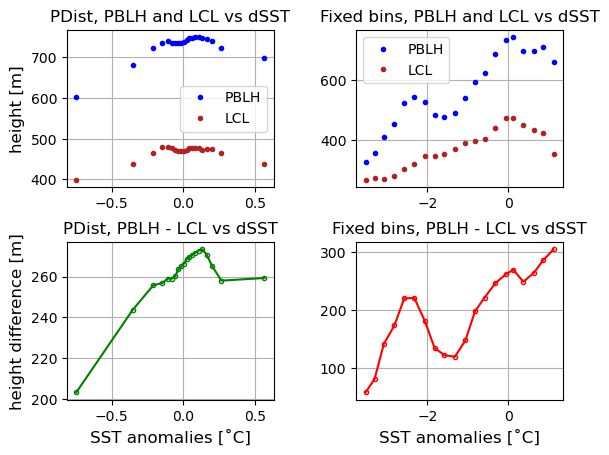

In [46]:
###### Figure
'''fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.'''

fig, ax = plt.subplots(2,2)

ax[0,0].plot(pdist_dsst, pdist_PBLH_dsst, '.',color='b', label='PBLH')
ax[0,0].plot(pdist_dsst, pdist_LCL_dsst, '.',color='firebrick', label='LCL')
ax[0,0].legend(loc=0)
ax[0,0].set_title(f'PDist, PBLH and LCL vs dSST') #perc_step={perc_step}')
ax[0,0].set_ylabel('height [m]', fontsize=12); #ax[0,0].set_xlabel('SST anomalies [˚C]', fontsize=12); 
ax[0,0].grid()

ax[1,0].plot(pdist_dsst, pdist_PBLH_dsst-pdist_LCL_dsst, '.-', color='g', mfc='none')
ax[1,0].set_title('PDist, PBLH - LCL vs dSST')
ax[1,0].set_ylabel('height difference [m]', fontsize=12); ax[1,0].set_xlabel('SST anomalies [˚C]', fontsize=12); ax[1,0].grid()

ax[0,1].plot(dist_dsst, dist_PBLH_dsst, '.', color='b', label='PBLH')
ax[0,1].plot(dist_dsst, dist_LCL_dsst, '.', color='firebrick', label='LCL')
ax[0,1].legend()
ax[0,1].set_title(f'Fixed bins, PBLH and LCL vs dSST')
#ax[0,1].set_ylabel('height [m]', fontsize=12)
#ax[0,1].set_xlabel('SST anomalies [˚C]', fontsize=12); 
ax[0,1].grid()

ax[1,1].plot(dist_dsst, dist_PBLH_dsst-dist_LCL_dsst, '.-', color='r', mfc='none')
ax[1,1].set_title('Fixed bins, PBLH - LCL vs dSST')
#ax[1,1].set_ylabel('height difference [m]', fontsize=12)
ax[1,1].set_xlabel('SST anomalies [˚C]', fontsize=12); ax[1,1].grid()


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.35)

#plt.savefig('/venus/tesi_ale/img_EU/PBLH-LCL/PBL_LCL_vs_dSST')

'''ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST anomalies [˚C]', fontsize=12); ax1.grid()
plt.xlim([ pdist_dsst[0] - (pdist_dsst[1]-pdist_dsst[0]),pdist_dsst[-1] + (pdist_dsst[1]-pdist_dsst[0]) ])'''

In [ ]:
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
# np.savetxt(path_bindist + 'pdist_dsst_day.txt', pdist_dsst)
np.savetxt(path_bindist + 'pdist_PBLH_dsst_day.txt', pdist_PBLH_dsst)
np.savetxt(path_bindist + 'pdist_LCL_dsst_day.txt', pdist_LCL_dsst)
np.savetxt(path_bindist + 'pstd_PBLH_dsst_day.txt', pstd_PBLH_dsst)
np.savetxt(path_bindist + 'pstd_LCL_dsst_day.txt', pstd_LCL_dsst)

In [ ]:
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/fullfield/'
np.savetxt(path_bindist + 'dist_dsst_day.txt', dist_dsst)
np.savetxt(path_bindist + 'dist_PBLH_dsst_day.txt', dist_PBLH_dsst)
np.savetxt(path_bindist + 'dist_LCL_dsst_day.txt', dist_LCL_dsst)
np.savetxt(path_bindist + 'std_err_PBLH_dsst_day.txt', std_err_PBLH_dsst)
np.savetxt(path_bindist + 'std_err_LCL_dsst_day.txt', std_err_LCL_dsst)
np.savetxt(path_bindist + 'npoint_PBLH_dsst_day.txt', npoint_PBLH_dsst)
np.savetxt(path_bindist + 'npoint_LCL_dsst_day.txt', npoint_LCL_dsst)

In [ ]:
# DISTRIBUTION dPBLH/dLCL vs dSST bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [ ]:
# PERC DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)

##### Perc distribution: PBLH
y = dPBLH_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dPBLH_dsst, pstd_dPBLH_dsst, pstd_err_dPBLH_dsst = perc_distribution(control, variable, nbins, perc_step)

##### Perc distribution: LCL
y = dLCL_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dLCL_dsst, pstd_dLCL_dsst, pstd_err_dLCL_dsst = perc_distribution(control, variable, nbins, perc_step)

In [ ]:
# FIXED BIN DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)

##### Fixed bin distribution: PBLH
y = dPBLH_day[:,:,:].copy()
variable = y.reshape(-1)
dist_dsst, dist_dPBLH_dsst, std_err_dPBLH_dsst, npoint_dPBLH_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)

##### Fixed bin distribution: LCL
y = dLCL_day[:,:,:].copy()
variable = y.reshape(-1)
dist_dsst, dist_dLCL_dsst, std_err_dLCL_dsst, npoint_dLCL_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)

In [ ]:
###### Figure
'''fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.'''

fig, ax = plt.subplots(1,2)


ax[0].plot(pdist_dsst, pdist_dPBLH_dsst, '.-',color='b', label='PBLH')
ax[0].plot(pdist_dsst, pdist_dLCL_dsst, '.-',color='firebrick', label='LCL')
ax[0].legend()

ax[0].set_ylabel('height anomalies [m]', fontsize=12); ax[0].set_xlabel('SST anomalies [˚C]', fontsize=12); 
ax[0].grid(); ax[0].set_title('PDist, dPBLH and dLCL vs dSST')
plt.xlim([ dist_dsst[0] - (dist_dsst[1]-dist_dsst[0]),dist_dsst[-1] + (dist_dsst[1]-dist_dsst[0]) ])




ax[1].plot(dist_dsst, dist_dPBLH_dsst, '.-',color='b', label='PBLH')
ax[1].plot(dist_dsst, dist_dLCL_dsst, '.-',color='firebrick', label='LCL')
ax[1].legend()

#ax[1].set_ylabel('height anoms[m]', fontsize=12); 
ax[1].set_xlabel('SST anomalies [˚C]', fontsize=12); 
ax[1].grid(); ax[1].set_title('Bins, dPBLH and dLCL vs dSST')
plt.xlim([ dist_dsst[0] - (dist_dsst[1]-dist_dsst[0]),dist_dsst[-1] + (dist_dsst[1]-dist_dsst[0]) ])


plt.subplots_adjust(wspace=0.45, 
                    hspace=0.3)


#plt.savefig('/home/alessandro/prove/primi_plot/pbl_mask/dPBL_dLCL_vs_dSST')

In [ ]:
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
# np.savetxt(path_bindist + 'pdist_dsst_day.txt', pdist_dsst)
np.savetxt(path_bindist + 'pdist_dPBLH_dsst_day.txt', pdist_dPBLH_dsst)
np.savetxt(path_bindist + 'pdist_dLCL_dsst_day.txt', pdist_dLCL_dsst)
np.savetxt(path_bindist + 'pstd_dPBLH_dsst_day.txt', pstd_dPBLH_dsst)
np.savetxt(path_bindist + 'pstd_dLCL_dsst_day.txt', pstd_dLCL_dsst)

In [ ]:
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/fullfield/'
np.savetxt(path_bindist + 'dist_dsst_day.txt', dist_dsst)
np.savetxt(path_bindist + 'dist_dPBLH_dsst_day.txt', dist_dPBLH_dsst)
np.savetxt(path_bindist + 'dist_dLCL_dsst_day.txt', dist_dLCL_dsst)
np.savetxt(path_bindist + 'std_err_dPBLH_dsst_day.txt', std_err_dPBLH_dsst)
np.savetxt(path_bindist + 'std_err_dLCL_dsst_day.txt', std_err_dLCL_dsst)
np.savetxt(path_bindist + 'npoint_dPBLH_dsst_day.txt', npoint_dPBLH_dsst)
np.savetxt(path_bindist + 'npoint_dLCL_dsst_day.txt', npoint_dLCL_dsst)

In [ ]:
# THERMODYNAMIC CONTRIBUTION

/venus/tesi_ale/img_EU/LH/daily/FEB/scatterFIT_sst_LH_feb.png


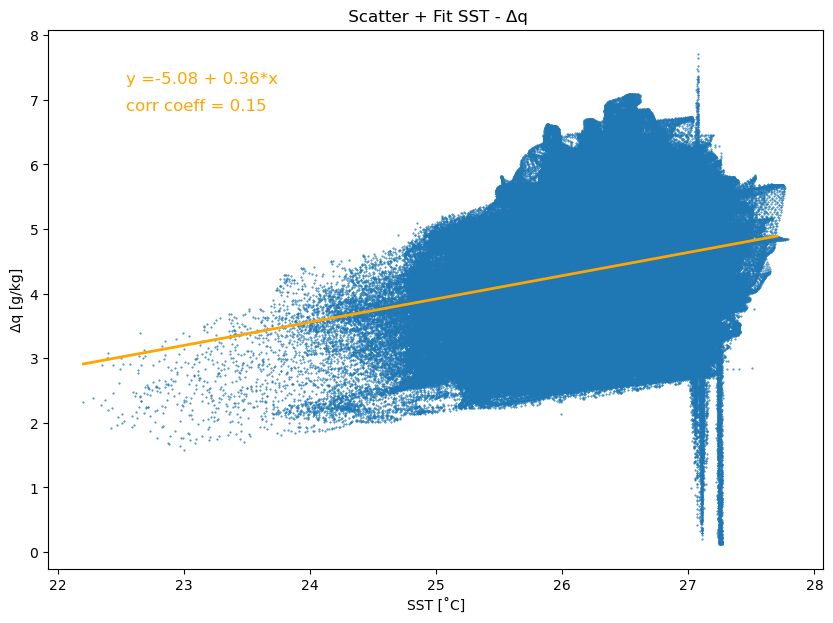

4.056158 <Unit('gram / kilogram')>

In [ ]:
# CCL - tentativo

In [10]:
# reading temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
pot_temp = pot_temp.where(sea_mask, drop=False)


T0 = 300. 

pot_temp_full = pot_temp+T0

In [11]:
# actual temperature
###### I DID NOT APPLY DAILY MEAN TO PRES!   ######
temperature = pot_temp * ( pres / 1000. )**0.286

In [6]:
# reading QVAPOR
QVAPOR_day = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')])
QVAPOR_day = QVAPOR_day['QVAPOR']

In [7]:
QVAPOR_day = QVAPOR_day.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

In [8]:
#####  CONTINUA A CRASHARE IL KERNEL A QUESTO PASSAGGIO  ######
# 11 Gb di dati qui
QVAPOR_day = QVAPOR_day.where(sea_mask, drop=False)

In [9]:
# compute daily averages!
QVAPOR_day = QVAPOR_day.groupby('time_counter.day').mean()

In [34]:
# compute daily averages!
pres = pres.groupby('time_counter.day').mean()
temperature = temperature.groupby('time_counter.day').mean()


In [48]:
pressure = np.array([1000, 990, 980])*units.hPa
tempsss = np.array([14, 10, 7])*units.degC
q2 = np.array([10, 7, 5])*units('g/kg')

#ccl_pres, ccl_temp, T_conv = mpcalc.ccl(pressure, tempsss, q2)


AttributeError: module 'metpy.calc' has no attribute 'ccl'

In [51]:
from inspect import getmembers, isfunction

import metpy.calc
print(getmembers(metpy.calc, isfunction))

[('absolute_momentum', <function absolute_momentum at 0x70f696126680>), ('absolute_vorticity', <function absolute_vorticity at 0x70f69e6bb9e0>), ('add_height_to_pressure', <function add_height_to_pressure at 0x70f6967ae9e0>), ('add_pressure_to_height', <function add_pressure_to_height at 0x70f6967aecb0>), ('advection', <function advection at 0x70f69e6b2b90>), ('ageostrophic_wind', <function ageostrophic_wind at 0x70f69e6bb4d0>), ('altimeter_to_sea_level_pressure', <function altimeter_to_sea_level_pressure at 0x70f6967b4b00>), ('altimeter_to_station_pressure', <function altimeter_to_station_pressure at 0x70f6967b4830>), ('angle_to_direction', <function angle_to_direction at 0x70f696126170>), ('apparent_temperature', <function apparent_temperature at 0x70f6967a69e0>), ('azimuth_range_to_lat_lon', <function azimuth_range_to_lat_lon at 0x70f696123710>), ('brunt_vaisala_frequency', <function brunt_vaisala_frequency at 0x70f69e70b830>), ('brunt_vaisala_frequency_squared', <function brunt_vai

In [46]:
##########       CCL EVIDENTLY NOT AVAILABLE IN METPY 1.2.0            ##########
##########       CCL EVIDENTLY NOT AVAILABLE IN METPY 1.2.0            ##########
##########       LATEST VERSION OF METPY 1.6.0 SUPPORTS PYTHON >= 3.9  ##########




t = pres.day.values - 1;  t = t[:,np.newaxis,np.newaxis]
i, j = np.arange(0,len(lon)), np.arange(0,len(lat))     # CHECK LON LAT
i, j = i[np.newaxis,np.newaxis,:], j[np.newaxis,:,np.newaxis]

# computation through ccl() in lcl.py
ccl_pres, ccl_temp, T_conv = np.zeros((len(t), len(lat), len(lon))), np.zeros((len(t), len(lat), len(lon))), np.zeros((len(t), len(lat), len(lon)))
ccl_pres[t,j,i], ccl_temp[t,j,i], T_conv[t,j,i] = lcl.ccl(pres.values[t,0:,j,i], temperature.values[t,0:,j,i], QVAPOR_day.values[t,0:,j,i]*1000.)   

AttributeError: module 'metpy.calc' has no attribute 'ccl'

In [ ]:
# HOURLY DATA

In [ ]:
# hourly varaibles
# select sst, q2, U, PBLH
sst = ds['SST'].values*seamask
PBLH = ds['PBLH'].values*seamask

In [ ]:
# read HOURLY LCL
LCL_file = '/media/fabien/DAGOBAH1/WRF_EUREC4A/CNT/FEB/LCL.nc'
ds_lcl = xr.open_dataset(LCL_file)

In [ ]:
LCL = ds_lcl['LCL'].values*seamask

In [ ]:
# compute anomalies hourly data
s = 50
dsst = np.zeros(sst.shape)
dPBLH = np.zeros(PBLH.shape); dLCL = np.zeros(LCL.shape)
for t in range(0,sst.shape[0]):
    if t % 100 == 0:
        print(t)
    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst[t],s)*seamask
    dsst[t] = sst[t] - sst_ave
    PBLH_ave = gm.nan_gaussian_filter(PBLH[t],s)*seamask
    dPBLH[t] = PBLH[t] - PBLH_ave
    LCL_ave = gm.nan_gaussian_filter(LCL[t],s)*seamask
    dLCL[t] = LCL[t] - LCL_ave

In [ ]:
# DISTRIBUTION dPBLH/dLCL vs dSST bin - HOURLY
thrsld_n = 100
perc_step = 5
nbins = int(100/perc_step) # Number of bins
x = dsst.copy()
control = x.reshape(-1)
##### Perc distribution: dPBLH
y = dPBLH[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dPBLH, pstd_err_dPBLH = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: dPBLH
dist_dsst, dist_dPBLH, std_err_dPBLH, npoint_dPBLH = fb_distribution_mod(control, variable, nbins, thrsld_n, perc_step)
##### Perc distribution: dLCL
y = dLCL[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dLCL, pstd_err_dLCL = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: dLCL
dist_dsst, dist_dLCL, std_err_dLCL, npoint_dLCL = fb_distribution_mod(control, variable, nbins, thrsld_n, perc_step)

(-3.7430357028209045, 1.3352971797346898)

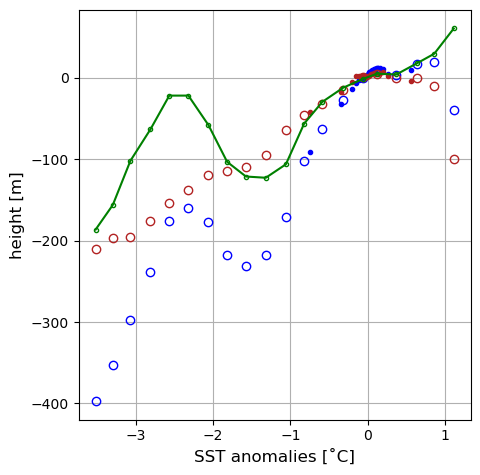

In [19]:
###### Figure
fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.

# ax1.errorbar(dist_dsst, dist_dPBLH, std_err_dPBLH, fmt='o', color='b', mfc='none')
# ax1.errorbar(pdist_dsst, pdist_dPBLH, pstd_err_dPBLH, fmt='.',color='b')
# ax1.errorbar(dist_dsst, dist_dLCL, std_err_dLCL, fmt='o', color='firebrick', mfc='none')
# ax1.errorbar(pdist_dsst, pdist_dLCL, pstd_err_dLCL, fmt='.',color='firebrick')

ax1.plot(dist_dsst, dist_dPBLH_dsst, 'o', color='b', mfc='none')
ax1.plot(pdist_dsst, pdist_dPBLH_dsst, '.',color='b')
ax1.plot(dist_dsst, dist_dLCL_dsst, 'o', color='firebrick', mfc='none')
ax1.plot(pdist_dsst, pdist_dLCL_dsst, '.',color='firebrick')

ax1.plot(dist_dsst, dist_dPBLH_dsst-dist_dLCL_dsst, '.-', color='g', mfc='none')

ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST anomalies [˚C]', fontsize=12); ax1.grid()
plt.xlim([ dist_dsst[0] - + (dist_dsst[1]-dist_dsst[0]),dist_dsst[-1] + (dist_dsst[1]-dist_dsst[0]) ])

In [ ]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/'
# PERC DISTRIBUTION
np.savetxt(path_bindist + 'pdist_dsst.txt', pdist_dsst)
np.savetxt(path_bindist + 'pdist_dPBLH.txt', pdist_dPBLH)
np.savetxt(path_bindist + 'pdist_dLCL.txt', pdist_dLCL)
np.savetxt(path_bindist + 'pstd_err_dPBLH.txt', pstd_err_dPBLH)
np.savetxt(path_bindist + 'pstd_err_dLCL.txt', pstd_err_dLCL)
# FB DISTRIBUTION (no point threshold)
np.savetxt(path_bindist + 'dist_dsst.txt', dist_dsst)
np.savetxt(path_bindist + 'dist_dPBLH.txt', dist_dPBLH)
np.savetxt(path_bindist + 'dist_dLCL.txt', dist_dLCL)
np.savetxt(path_bindist + 'std_err_dPBLH.txt', std_err_dPBLH)
np.savetxt(path_bindist + 'std_err_dLCL.txt', std_err_dLCL)
np.savetxt(path_bindist + 'npoint_dPBLH.txt', npoint_dPBLH)
np.savetxt(path_bindist + 'npoint_dLCL.txt', npoint_dLCL)

In [ ]:
# corr length
L = 80
nskip = int(L/3)
nt = int(3)
nbin = 50

# linear regression PBLH vs SST
x = dsst_day[::nt,::nskip,::nskip].copy()
# y = dPBLH[::nt,::nskip,::nskip].copy()
y = (dPBLH_day - dLCL_day)[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

# scatterplot lin regression 
title = "PBLH' vs SST' - sigma "
xlabel = 'SST anomalies [°C]'; ylabel = "PBLH anomalies [m]"

fig1 = scatterplot_fit(x, y, linreg_res, title, xlabel, ylabel, fig)  
plt.annotate(f'correl = {round(corr_coeff,2)}', xy=(-1.45, 100), )   # xycoords='axes fraction', fontsize=12, color='orange'

'''# histogram 2d 
plt.subplot(1,2,2)
fig2 = hist2d(x, y, s, nbin, title, xlabel, ylabel, fig)'''

In [ ]:
# PLOT DATA

In [ ]:
##############
# BOXPLOT
##############

In [ ]:
# BOXPLOT
def box_plot(data, labels, edge_color, fill_color, ax):
    medianprops = dict(linestyle='-', linewidth=1, color=edge_color)
    meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor=edge_color, markersize=4)
    flierprops = dict(marker='o', markeredgecolor=edge_color, markersize=6,
                  linestyle='none')
    
    bp = ax.boxplot(data, labels=labels, medianprops=medianprops, flierprops=flierprops, \
                    meanprops=meanpointprops, showmeans=True, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

def box_plot_pos(data, offset, labels, edge_color, fill_color, ax):
    medianprops = dict(linestyle='-', linewidth=1, color=edge_color)
    meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor=edge_color, markersize=4)
    flierprops = dict(marker='o', markeredgecolor=edge_color, markersize=6,
                  linestyle='none')
    
    pos = np.arange(len(labels))+offset
    
    bp = ax.boxplot(data, positions= pos, labels=labels, medianprops=medianprops, flierprops=flierprops, \
                    meanprops=meanpointprops, showmeans=True, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

In [ ]:
# build sst perc classes
perc = np.arange(10,100,10)
sst_day_perc = np.zeros(len(perc))
dsst_day_perc = np.zeros(len(perc))

for i in range(0,len(perc)):
    sst_day_perc[i] = np.nanpercentile(sst_day,perc[i])
    dsst_day_perc[i] = np.nanpercentile(dsst_day,perc[i])

In [ ]:
bin_PBLH_sst = []; bin_LCL_sst = []
bin_PBLH_dsst = []; bin_LCL_dsst = []
bin_dPBLH_dsst = []; bin_dLCL_dsst = []
labels = []; dlabels = []
for i in range(0,len(perc)):
    if i == 0:
        pblh_sst = PBLH_day[sst_day < sst_day_perc[i]]; lcl_sst = LCL_day[sst_day < sst_day_perc[i]]
        pblh_dsst = PBLH_day[dsst_day < dsst_day_perc[i]]; lcl_dsst = LCL_day[dsst_day < dsst_day_perc[i]]
        dpblh_dsst = dPBLH_day[dsst_day < dsst_day_perc[i]]; dlcl_dsst = dLCL_day[dsst_day < dsst_day_perc[i]]
    else:
        pblh_sst = PBLH_day[(sst_day >= sst_day_perc[i-1]) & (sst_day < sst_day_perc[i])]
        pblh_dsst = PBLH_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
        dpblh_dsst = dPBLH_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
        lcl_sst = LCL_day[(sst_day >= sst_day_perc[i-1]) & (sst_day < sst_day_perc[i])]
        lcl_dsst = LCL_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
        dlcl_dsst = dLCL_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
    # create lists
    bin_PBLH_sst.append(pblh_sst); bin_LCL_sst.append(lcl_sst)
    bin_PBLH_dsst.append(pblh_dsst); bin_LCL_dsst.append(lcl_dsst)
    bin_dPBLH_dsst.append(dpblh_dsst); bin_dLCL_dsst.append(dlcl_dsst)
    labels.append(str(np.round(sst_day_perc[i]-273.15,2)))
    dlabels.append(str(np.round(dsst_day_perc[i],2)))
# adding last class, when data > 90perc sst
pblh_sst = PBLH_day[sst_day >= sst_day_perc[-1]]; lcl_sst = LCL_day[sst_day >= sst_day_perc[-1]]
pblh_dsst = PBLH_day[dsst_day >= dsst_day_perc[-1]]; lcl_dsst = LCL_day[dsst_day >= dsst_day_perc[-1]]
dpblh_dsst = dPBLH_day[dsst_day >= dsst_day_perc[-1]]; dlcl_dsst = dLCL_day[dsst_day >= dsst_day_perc[-1]]
bin_PBLH_sst.append(pblh_sst); bin_LCL_sst.append(lcl_sst)
bin_PBLH_dsst.append(pblh_dsst); bin_LCL_dsst.append(lcl_dsst)
bin_dPBLH_dsst.append(dpblh_dsst); bin_dLCL_dsst.append(dlcl_dsst)
labels.append(' '); dlabels.append(' ')       

In [ ]:
# BOXPLOT SOVRAPPOSTO
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 12))

bp1 = box_plot(bin_PBLH_sst, labels, 'blue', 'white', ax1)
bp2 = box_plot(bin_LCL_sst, labels, 'firebrick', 'white', ax1)
ax1.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax1.set_xlabel('SST [˚C]', fontsize=12); ax1.set_ylabel('height [m]', fontsize=12)

bp1 = box_plot(bin_PBLH_dsst, dlabels, 'blue', 'white', ax2)
bp2 = box_plot(bin_LCL_dsst, dlabels, 'firebrick', 'white', ax2)
ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax2.set_xlabel('SST anom [˚C]', fontsize=12); ax2.set_ylabel('height [m]', fontsize=12)

bp1 = box_plot(bin_dPBLH_dsst, dlabels, 'blue', 'white', ax3)
bp2 = box_plot(bin_dLCL_dsst, dlabels, 'firebrick', 'white', ax3)
ax3.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax3.set_xlabel('SST anom [˚C]', fontsize=12); ax3.set_ylabel('height anom [m]', fontsize=12)

In [ ]:
# BOXPLOT AFFIANCATO
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 12))

offs = 0.25

bp1 = box_plot_pos(bin_PBLH_sst, 0, labels, 'blue', 'white', ax1)
bp2 = box_plot_pos(bin_LCL_sst, offs, labels, 'firebrick', 'white', ax1)
ax1.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax1.set_xlabel('SST [˚C]', fontsize=12); ax1.set_ylabel('height [m]', fontsize=12)
ax1.set_xticks(np.arange(len(labels)))

bp1 = box_plot_pos(bin_PBLH_dsst, 0, dlabels, 'blue', 'white', ax2)
bp2 = box_plot_pos(bin_LCL_dsst, offs, dlabels, 'firebrick', 'white', ax2)
ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax2.set_xlabel('SST anom [˚C]', fontsize=12); ax2.set_ylabel('height [m]', fontsize=12)
ax2.set_xticks(np.arange(len(labels)))

bp1 = box_plot_pos(bin_dPBLH_dsst, 0, dlabels, 'blue', 'white', ax3)
bp2 = box_plot_pos(bin_dLCL_dsst, offs, dlabels, 'firebrick', 'white', ax3)
ax3.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax3.set_xlabel('SST anom [˚C]', fontsize=12); ax3.set_ylabel('height anom [m]', fontsize=12)
ax3.set_xticks(np.arange(len(labels)))

In [ ]:
# HOURLY

In [ ]:
bin_dPBLH = [dPBLH[dsst < -1.5], \
            dPBLH[(dsst >= -1.5) & (dsst < -1)], \
            dPBLH[(dsst >= -1) & (dsst < -0.5)], \
            dPBLH[(dsst >= -0.5) & (dsst < 0)], \
            dPBLH[(dsst >= 0) & (dsst < 0.5)], \
            dPBLH[(dsst >= 0.5) & (dsst < 1)], \
            dPBLH[dsst >= 1]]
bin_dLCL = [dLCL[dsst < -1.5], \
            dLCL[(dsst >= -1.5) & (dsst < -1)], \
            dLCL[(dsst >= -1) & (dsst < -0.5)], \
            dLCL[(dsst >= -0.5) & (dsst < 0)], \
            dLCL[(dsst >= 0) & (dsst < 0.5)], \
            dLCL[(dsst >= 0.5) & (dsst < 1)], \
            dLCL[dsst >= 1]]

dlabels = ['-1.5', '-1', '-0.5', '0', '0.5', '1', '1+']

In [ ]:
fig, ax = plt.subplots()
bp1 = box_plot_pos(bin_dPBLH, 0, dlabels, 'blue', 'white')
bp2 = box_plot_pos(bin_dLCL, 0.2, dlabels, 'firebrick', 'white')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['dPBLH', 'dLCL'])
ax.set_xticks(np.arange(len(labels)))
ax.set_xlabel('SST [˚C]', fontsize=12); ax.set_ylabel('height [m]', fontsize=12)

In [ ]:
# READ DATA

In [ ]:
# DAILY
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
pdist_sst = np.loadtxt(path_bindist + 'pdist_sst.txt')
pdist_PBLH = np.loadtxt(path_bindist + 'pdist_PBLH.txt')
pdist_LCL = np.loadtxt(path_bindist + 'pdist_LCL.txt')
pstd_err_PBLH = np.loadtxt(path_bindist + 'pstd_PBLH.txt')
pstd_err_LCL = np.loadtxt(path_bindist + 'pstd_LCL.txt')
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/'
dist_sst = np.loadtxt(path_bindist + 'dist_sst.txt')
dist_PBLH = np.loadtxt(path_bindist + 'dist_PBLH.txt')
dist_LCL = np.loadtxt(path_bindist + 'dist_LCL.txt')
std_err_PBLH = np.loadtxt(path_bindist + 'std_err_PBLH.txt')
std_err_LCL = np.loadtxt(path_bindist + 'std_err_LCL.txt')
npoint_PBLH = np.loadtxt(path_bindist + 'npoint_PBLH.txt')
npoint_LCL = np.loadtxt(path_bindist + 'npoint_LCL.txt')

In [ ]:
# HOURLY
# PERC DISTRIBUTION
pdist_dsst = np.loadtxt(path_bindist + 'pdist_dsst.txt')
pdist_dPBLH = np.loadtxt(path_bindist + 'pdist_dPBLH.txt')
pdist_dLCL = np.loadtxt(path_bindist + 'pdist_dLCL.txt')
pstd_err_dPBLH = np.loadtxt(path_bindist + 'pstd_err_dPBLH.txt')
pstd_err_dLCL = np.loadtxt(path_bindist + 'pstd_err_dLCL.txt')
# FB DISTRIBUTION (no point threshold)
dist_dsst = np.loadtxt(path_bindist + 'dist_dsst.txt')
dist_dPBLH = np.loadtxt(path_bindist + 'dist_dPBLH.txt')
dist_dLCL = np.loadtxt(path_bindist + 'dist_dLCL.txt')
std_err_dPBLH = np.loadtxt(path_bindist + 'std_err_dPBLH.txt')
std_err_dLCL = np.loadtxt(path_bindist + 'std_err_dLCL.txt')
npoint_dPBLH = np.loadtxt(path_bindist + 'npoint_dPBLH.txt')
npoint_dLCL = np.loadtxt(path_bindist + 'npoint_dLCL.txt')

In [ ]:
# OLD STUFF

In [ ]:
# grid and geographical coordinates of seemingly good points; 
# format: [j,i] i.e. [lat, lon]
# sure there is a better way to do it

# small rectangle
small_gpoints = [[350,410],[350,265],[65,265],[65,410]]; small_gpoints=np.array(small_gpoints)
small_coords = np.zeros_like(small_gpoints)

for i in range(len(small_gpoints[:,0])):
    small_coords[i,0], small_coords[i,1] = ds_tot.nav_lat.sel(y=small_gpoints[i,0],x=small_gpoints[i,1]), ds_tot.nav_lon.sel(y=small_gpoints[i,0],x=small_gpoints[i,1])

small_coords=np.array(small_coords)


# large rectangle
large_gpoints = [[410,410],[65,410],[65,800],[410,800]]; large_gpoints=np.array(large_gpoints)
large_coords = np.zeros_like(large_gpoints)

for i in range(len(large_gpoints[:,0])):
    large_coords[i,0], large_coords[i,1] = ds_tot.nav_lat.sel(y=large_gpoints[i,0],x=large_gpoints[i,1]),\
                                           ds_tot.nav_lon.sel(y=large_gpoints[i,0],x=large_gpoints[i,1])
    
large_coords=np.array(large_coords)


# optional expansion
add_gpoints = [[410,800],[65,800],[65,900],[410,900]]; add_gpoints=np.array(add_gpoints)
add_coords = np.zeros_like(add_gpoints)

for i in range(len(small_gpoints[:,0])):
    add_coords[i,0], add_coords[i,1] = ds_tot.nav_lat.sel(y=add_gpoints[i,0],x=add_gpoints[i,1]), \
                                       ds_tot.nav_lon.sel(y=add_gpoints[i,0],x=add_gpoints[i,1])

add_coords=np.array(add_coords)

In [ ]:
minlon = min(small_coords[:,1]) ; maxlon = max(small_coords[:,1])      
minlat = min(small_coords[:,0]) ; maxlat = max(small_coords[:,0])     

In [ ]:
# domain selection new
'''mask_lon = (ds_tot.nav_lon_grid_M >= min(large_coords[:,1])) & (ds_tot.nav_lon_grid_M <= max(large_coords[:,1]))
mask_lat = (ds_tot.nav_lat_grid_M >= min(large_coords[:,0])) & (ds_tot.nav_lat_grid_M <= max(large_coords[:,0]))'''



# select domain - large box
mask_lon = (ds_month.nav_lon >= minlon) & (ds_month.nav_lon <= maxlon)
mask_lat = (ds_month.nav_lat >= minlat) & (ds_month.nav_lat <= maxlat)
ds_domain = ds_month.where(mask_lon & mask_lat, drop=True)